# Lab 1: MNIST Classification

- Complete the following tasks
- Save and submit your Jupytor notebook

## MNIST reference:
- http://yann.lecun.com/exdb/mnist/

## PyTorch reference:
- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html
- https://pytorch.org/docs/stable/index.html

In [1]:
# read data from the csv file (i.e., ../mnist/mnist.csv) with pandas
# convert data into numpy arrays
import numpy as np
import pandas as pd

%time data = pd.read_csv("../mnist/mnist.csv", header=None).values
img = data[:, 1:].reshape((-1, 28, 28))
lab = data[:, 0]
one = np.zeros((len(lab), 10))
one[range(len(lab)), lab] = 1
data = None

CPU times: user 1.97 s, sys: 380 ms, total: 2.35 s
Wall time: 2.35 s


In [2]:
# check loaded data by showing some key properties

print("#image shape:", img.shape)
print("#label shape:", lab.shape)
print("#one-hot vector shape:", one.shape)
print("#label distribution:", *np.mean(one, axis=0))

#image shape: (70000, 28, 28)
#label shape: (70000,)
#one-hot vector shape: (70000, 10)
#label distribution: 0.09861428571428571 0.11252857142857142 0.09985714285714285 0.10201428571428571 0.09748571428571429 0.09018571428571429 0.09822857142857143 0.10418571428571428 0.0975 0.0994


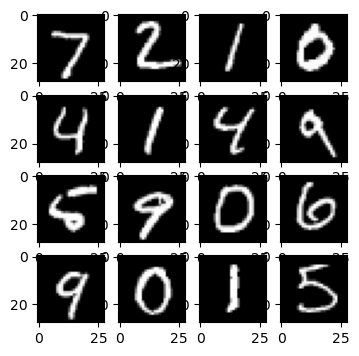

In [3]:
# check loaded data by showing a few images
import matplotlib.pyplot as plt
%matplotlib inline

size = 4
plt.figure(figsize=(size, size))
for i in range(size*size):
  plt.subplot(size, size, i+1)
  plt.imshow(img[i], cmap='gray')

In [4]:
# check loaded data by showing a few labels

print("#label:", lab[: size * size])
print("#one-hot vector:", one[: size * size])

#label: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
#one-hot vector: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [5]:
# split the dataset into training and validation datasets
from sklearn.model_selection import train_test_split

img = img.reshape((len(img), -1)) / 256
img_train, img_valid, lab_train, lab_valid, one_train, one_valid = train_test_split(
    img, lab, one, test_size=0.2, random_state=7)
print('#image:', img_train.shape, img_valid.shape)
print('#label:', lab_train.shape, lab_valid.shape)
print('#one-hot vector:', one_train.shape, one_valid.shape)

#image: (56000, 784) (14000, 784)
#label: (56000,) (14000,)
#one-hot vector: (56000, 10) (14000, 10)


# Lab Requirements

Rewrite the following cells to train and to evaluate the same neural network without using any Deep Learning APIs. That means you can only use NumPy or Tensors, but you cannot use torch.nn or torch.optim.


In [6]:
# prepare the data loaders for training

from torch.utils.data import TensorDataset, DataLoader
import random
import torch as pt


batchsize = 64

# add your codes here

dev = random.randint(0, pt.cuda.device_count()-1)
pt.cuda.set_device(dev)
print('#device:', dev)

img_train = pt.from_numpy(img_train).float()
img_valid = pt.from_numpy(img_valid).float()
one_train = pt.from_numpy(one_train).float()
one_valid = pt.from_numpy(one_valid).int()
data_train = DataLoader(TensorDataset(img_train, one_train),
                        batch_size=batchsize, shuffle=True, drop_last=True)
data_valid = DataLoader(TensorDataset(img_valid, one_valid),
                        batch_size=batchsize, shuffle=False, drop_last=True)

#device: 4


In [7]:
from tqdm.notebook import tqdm


class neuralnetwork(pt.nn.Module):
    def __init__(self, inodes, hnodes, onodes, lr) -> None:
        super(neuralnetwork, self).__init__()
        self.lr = lr
        # model parameters
        self.w1 = pt.randn([inodes, hnodes]) / 100  # 784×256
        self.b1 = pt.zeros(hnodes)  # 256
        self.w2 = pt.randn([hnodes, onodes]) / 100  # 256×10
        self.b2 = pt.zeros(onodes)  # 10

    def train_val(self, train_data,val_data):
        running_loss = []
        for x, y in tqdm(train_data):
            hi = x @ self.w1 + self.b1                                                # [batch_size,784]@[784,256]=[64,256]
            ho = pt.where(hi > 0, hi, pt.zeros_like(hi))                              # ReLU [64,256]

            fi = ho @ self.w2 + self.b2                                               # [64,256]@[256,10]=[64,10]
            fo = pt.softmax(fi, dim=1)                                                # [64,10]
            # ∵ dfo/dfi = e^fi(Σe^j-e^fi)/(Σe^j)^2 = fo(1-fo)

            loss = -y*pt.log(fo)+(y-1.0)*pt.log(1.0-fo)   
            running_loss.append(loss)                            # cross entropy [64,10]

            # 又∵ dloss/dfo = -y/fo + (1-y)/(1-fo)
            # ∴ dloss/dfi = -y(1-fo) + (1-y)fo = -y+fo
            grad_fi = -y+fo                                                            # [64,10]
            grad_w2 = ho.reshape((-1, 256, 1)) @ grad_fi.reshape((-1, 1, 10))          # 256×10
            grad_b2 = grad_fi  # [64,10]

            grad_ho = grad_fi @ self.w2.t()                                            # [64,10]@[10,256]=[64,256]
            # 原来≤0的导数为0，原来＞0的导数为1
            grad_hi = grad_ho * pt.where(hi > 0, pt.ones_like(hi), pt.zeros_like(hi))  # [64,256]
            grad_w1 = x.reshape((-1, 784, 1)) @ grad_hi.reshape((-1, 1, 256))          # [784,256]
            grad_b1 = grad_ho                                                          # [64,256]
            # 使用梯度的平均值来更新参数可以更好地代表整个训练集的梯度方向，减小参数更新的方差，并减少训练过程中的震荡现象，从而提高模型的训练效果和稳定性
            self.w2 -= self.lr*pt.mean(grad_w2,axis=0)
            self.b2 -= self.lr*pt.mean(grad_b2,axis=0)
            self.w1 -= self.lr*pt.mean(grad_w1,axis=0)
            self.b1 -= self.lr*pt.mean(grad_b1,axis=0)

            
        running_acc=[]
        for x,y in val_data:
            hi = x @ self.w1 + self.b1                                                # [batch_size,784]@[784,256]=[64,256]
            ho = pt.where(hi > 0, hi, pt.zeros_like(hi))                              # ReLU [64,256]

            fi = ho @ self.w2 + self.b2                                               # [64,256]@[256,10]=[64,10]
            # 不需要softmax因为知道最大的那个就行
            label=pt.argmax(fi,axis=1,keepdim=True)  # 因为第一维是64
            
            acc=float(pt.sum(label==pt.argmax(y,axis=1,keepdim=True)))/batchsize
            running_acc.append(acc)
        print("loss: %.4f \n acc: %.2f%%" %(np.mean(running_loss),np.mean(running_acc)*100))


In [8]:
# implement a simple neural network model
# with a single hidden layer of 256 neurons and a ReLU activation function
# without using torch.nn

# train the model for 10 epochs
# with the stochastic gradient descent algorithm
# without using torch.optim

# evaluate the classification accuracy after training each epoch

# training parameters
eps = 1e-6

learning_rate = 0.1

# add your codes here
n = neuralnetwork(28*28, 256, 10, learning_rate)
for epoch in range(10):
    print("epoch: " ,epoch)
    n.train_val(data_train,data_valid)

epoch:  0


  0%|          | 0/875 [00:00<?, ?it/s]

loss: 0.0858 
 acc: 91.94%
epoch:  1


  0%|          | 0/875 [00:00<?, ?it/s]

loss: 0.0416 
 acc: 93.74%
epoch:  2


  0%|          | 0/875 [00:00<?, ?it/s]

loss: 0.0317 
 acc: 94.95%
epoch:  3


  0%|          | 0/875 [00:00<?, ?it/s]

loss: nan 
 acc: 95.75%
epoch:  4


  0%|          | 0/875 [00:00<?, ?it/s]

loss: nan 
 acc: 96.19%
epoch:  5


  0%|          | 0/875 [00:00<?, ?it/s]

loss: nan 
 acc: 96.65%
epoch:  6


  0%|          | 0/875 [00:00<?, ?it/s]

loss: nan 
 acc: 96.82%
epoch:  7


  0%|          | 0/875 [00:00<?, ?it/s]

loss: nan 
 acc: 96.91%
epoch:  8


  0%|          | 0/875 [00:00<?, ?it/s]

loss: nan 
 acc: 97.15%
epoch:  9


  0%|          | 0/875 [00:00<?, ?it/s]

loss: nan 
 acc: 97.17%
